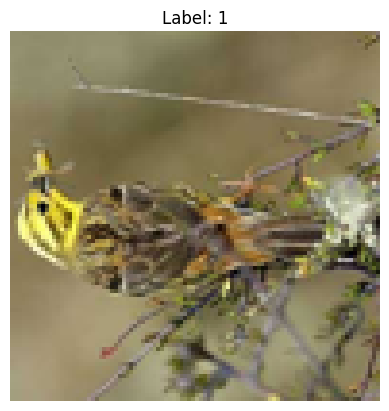

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

DATA_PATH = "../data/stl10_binary"  # binary 파일이 있는 디렉토리
IMG_SIZE = 96
NUM_CHANNELS = 3

# load image function
def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
        data = np.transpose(data, (0, 2, 3, 1))  # (N, H, W, C)
        return data

# load label 
def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels - 1  # 0-based indexing으로 바꿈

# example
X_train = read_all_images(os.path.join(DATA_PATH, "train_X.bin"))
y_train = read_labels(os.path.join(DATA_PATH, "train_y.bin"))
X_test = read_all_images(os.path.join(DATA_PATH, "test_X.bin"))
y_test = read_labels(os.path.join(DATA_PATH, "test_y.bin"))
# 이미지 확인
plt.imshow(X_train[0])
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


In [ ]:
import cv2
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Harris corner detector
def extract_harris_features(images):
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        keypoints = np.argwhere(harris_corners > 0.01 * harris_corners.max())
        keypoints = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in keypoints]
        sift = cv2.SIFT_create()
        _, descriptors = sift.compute(gray, keypoints)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list


harris_train_descriptors = extract_harris_features(X_train)
harris_test_descriptors = extract_harris_features(X_test)


# Combine all features into one array
all_descriptors = np.vstack(harris_train_descriptors)

# Generate visual words using KMeans clustering
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_descriptors)

def create_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            cluster_indices = kmeans.predict(descriptors)
            for idx in cluster_indices:
                histogram[idx] += 1
        histograms.append(histogram)
    return np.array(histograms)

train_histograms = create_histograms(harris_train_descriptors, kmeans)
test_histograms = create_histograms(harris_test_descriptors, kmeans)

# Normalize histogram
scaler = StandardScaler()
train_histograms = scaler.fit_transform(train_histograms)
test_histograms = scaler.transform(test_histograms)

# SVM model train and evaluate
svm_model = svm.SVC()
svm_model.fit(train_histograms, y_train)
svm_predictions = svm_model.predict(test_histograms)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Harris + BoVW + SVM Accuracy: {svm_accuracy}")




Harris + BoVW + SVM Accuracy: 0.3905
